![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from Jewelry Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.

The dataset used for this work is from Kaggle [eCommerce purchase history from jewelry store](https://www.kaggle.com/mkechinov/ecommerce-purchase-history-from-jewelry-store):

## Context

This is a item purchased transactions data. It has 8 columns.
This data makes you familer with transactions data.

## Content

Data description is :-

* UserId -It is a unique ID for all User Id
* TransactionId -It contains unique Transactions ID
* TransactionTime -It contains Transaction Time
* ItemCode -It contains item code that item will be purchased
* ItemDescription -It contains Item description
* NumberOfItemPurchased -It contains total number of items Purchased
* CostPerltem -Cost per item Purchased
* Country -Country where item purchased

## Basics of EDA

Here are a few things that we are looking for in the invoice / transaction data:

1. Were there any negative totals? If so why?
2. What percentage of the purchases actually contained multiple items?
3. What is the spread of purchases by customer ID? Do we have a few customers whose behavior may drive recommendations in a way that doesn't fit the average customer?
4. Where there any purchases that were VERY large? If so why? Do we want to include these values to train model behavior?
5. Is there any missing data that we need to scrub?


In [ ]:
%reload_kedro

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [2]:
transactions = catalog.load("jewelry_kaggle_data")

transactions.head()

2022-03-05 13:57:07,874 - kedro.io.data_catalog - INFO - Loading data from `jewelry_kaggle_data` (CSVDataSet)...


,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem
0,2018-11-29 16:30:45 UTC,1923415742179443254,1836250225916772582,1,1.806829e+18,jewelry.pendant,0.0,67.78,1.515916e+18,NaN,red,gold,diamond
1,2018-11-29 16:52:07 UTC,1923426489303302817,1836015460420681761,1,1.806829e+18,jewelry.pendant,0.0,32.63,1.515916e+18,NaN,red,gold,NaN
2,2018-11-29 17:58:37 UTC,1923459963229831173,1806829194936582544,1,1.806829e+18,jewelry.ring,1.0,75.21,1.515916e+18,NaN,red,gold,amethyst
3,2018-11-29 20:25:52 UTC,1923534078074684181,1835566854668550661,1,1.806829e+18,jewelry.earring,0.0,131.37,1.515916e+18,f,red,gold,NaN
4,2018-11-29 20:30:01 UTC,1923536169069445939,1836568752905257618,1,1.806829e+18,jewelry.bracelet,0.0,102.60,1.515916e+18,f,red,gold,NaN


# Checking for missing data

In [3]:
print('Total length is',len(transactions))
transactions.isna().sum()

Total length is 113302


event_time           0
order_id             0
product_id           0
quantity             0
category_id        397
category_code     9628
brand             1366
price              397
user_id            397
gender           51079
color             3136
metal              451
gem              36207
dtype: int64

There are 85604 unique orders

Here are the counts of orders ordered from largest to smallest
[30 30 29 ...  1  1  1]

And a graph of what the curve looks like:


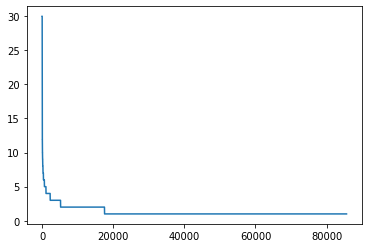

In [5]:
transaction_counts = transactions['order_id'].value_counts().to_numpy()
print('There are', len(transaction_counts), 'unique orders\n')
print('Here are the counts of orders ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts) 
plt.show()

# User Interactions

Let's take a look at how many unique customers are included in this dataset

There are 45194 unique customers

Here are the counts of transactions per customer ordered from largest to smallest
[560 515 504 ...   1   1   1]

And a graph of what the curve looks like:


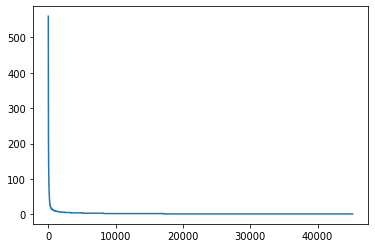

In [6]:
user_counts = transactions['user_id'].value_counts().to_numpy()
print('There are', len(user_counts), 'unique customers\n')
print('Here are the counts of transactions per customer ordered from largest to smallest')
print(user_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(user_counts) 
plt.show()

In [7]:
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.0f}'.format


transactions.groupby(['user_id'])['user_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,user_id,count
7785,1515915625245643008,560
5050,1515915625214139648,515
1834,1515915625141568512,504
6052,1515915625230255872,489
4961,1515915625212567552,471
4462,1515915625203784960,445
2348,1515915625155809024,442
1079,1515915625078636800,415
20756,1515915625337818112,402
4563,1515915625205818624,365


In [8]:
transactions[transactions.user_id == 1515915625245643008].groupby(transactions.order_id).count()

,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem
order_id,,,,,,,,,,,,,
1960131611911520624,3,3,3,3,3,3,3,3,3,0,3,3,0
1960150518852485735,2,2,2,2,2,2,2,2,2,0,2,2,2
1960291835758772573,1,1,1,1,1,1,1,1,1,1,1,1,1
1964403586225930499,1,1,1,1,1,1,1,1,1,0,1,1,1
1971077303844733593,1,1,1,1,1,1,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450892709234213095,2,2,2,2,2,2,2,2,2,1,2,2,2
2450930952302493736,2,2,2,2,2,0,2,2,2,0,2,2,0
2451621567549932273,2,2,2,2,2,2,2,2,2,1,2,2,2


It appears that there are a lot of different transactions, so probably not just the same thing being purchased over and over. Not really sure what to do with this at the moment.

# Transactions over Time

Now we need to look at the number of items purchased each day to see if there is anything interesting that pops out.

In [30]:
from datetime import datetime

datetime_object = datetime.strptime('2018-11-29 16:30:45 UTC', '%Y-%m-%d %H:%M:%S UTC')

def func(date):
    temp = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S UTC')
    return temp
#     return temp.strftime('%Y%m%d')

transactions['datetime'] = transactions.apply(lambda x: func(x.event_time), axis=1)


In [51]:
transactions.dtypes

event_time               object
order_id                  int64
product_id                int64
quantity                  int64
category_id             float64
category_code            object
brand                   float64
price                   float64
user_id                 float64
gender                   object
color                    object
metal                    object
gem                      object
datetime         datetime64[ns]
stock_total             float64
dtype: object

In [50]:
transactions.groupby(transactions['datetime'].dt.dayofweek).count()

,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem,datetime,stock_total
datetime,,,,,,,,,,,,,,,
0,15029,15029,15029,15029,15029,13846,14810,15029,15029,8280,14639,15022,10359,15029,15029
1,16500,16500,16500,16500,16500,15020,16293,16500,16500,9039,16162,16488,11246,16500,16500
2,16365,16365,16365,16365,16365,14945,16154,16365,16365,9089,15945,16353,11155,16365,16365
3,17892,17892,17892,17892,17892,16376,17663,17892,17892,9979,17459,17886,12338,17892,17892
4,17290,17290,17290,17290,17290,15791,17122,17290,17290,9490,16915,17284,11831,17290,17290
5,15357,15357,15357,15357,15357,14071,15189,15357,15357,8401,14977,15352,10465,15357,15357
6,14472,14472,14472,14472,14472,13228,14308,14472,14472,7945,14069,14466,9701,14472,14472


In [52]:
transactions.groupby(transactions['datetime'].dt.hour).count()

,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem,datetime,stock_total
datetime,,,,,,,,,,,,,,,
0,472,472,472,472,472,433,468,472,472,282,462,472,339,472,472
1,414,414,414,414,414,386,409,414,414,245,404,414,300,414,414
2,567,567,567,567,567,525,561,567,567,340,553,567,388,567,567
3,1218,1218,1218,1218,1218,1101,1214,1218,1218,685,1199,1217,859,1218,1218
4,1714,1714,1714,1714,1714,1559,1702,1714,1714,1028,1685,1713,1213,1714,1714
5,2959,2959,2959,2959,2959,2723,2930,2959,2959,1651,2886,2958,2056,2959,2959
6,4619,4619,4619,4619,4619,4239,4582,4619,4619,2585,4503,4613,3250,4619,4619
7,6676,6676,6676,6676,6676,6103,6587,6676,6676,3703,6519,6672,4634,6676,6676
8,7889,7889,7889,7889,7889,7193,7788,7889,7889,4383,7687,7883,5393,7889,7889


<AxesSubplot:>

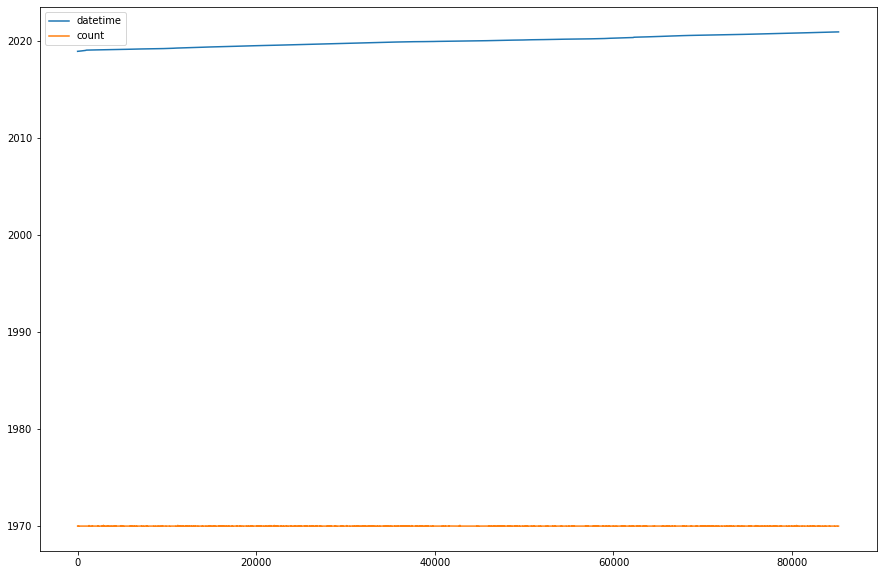

In [53]:
transactions.groupby(['datetime'])['datetime'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['datetime'], ascending=True) \
                             .plot(figsize=(15,10))

# Checking Invoice Totals

We need to make sure all the invoice totals that we're using are positive - this keeps us from using invoices that captured customer returned items.

<AxesSubplot:xlabel='order_id'>

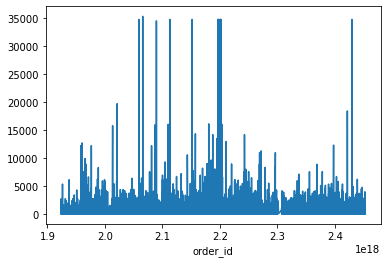

In [11]:
transactions['stock_total'] = transactions['quantity'] * transactions['price']
totals = transactions.groupby(transactions.order_id)['stock_total'].sum()
totals.plot()

In [12]:
totals.sort_values(ascending=False)

order_id
2065786108280570192   35276
2202208873731850475   34724
2151787699957138344   34724
2429860195271180647   34724
2059085943419175765   34724
                       ... 
2236276771345399947       0
2434300277927445487       0
1984811348827046445       0
2438643528641806346       0
2309477565770760276       0
Name: stock_total, Length: 85604, dtype: float64

In [13]:
print('There are', len(transactions[transactions.quantity < 0]), 'negative quantities')
transactions[transactions.quantity < 0].head()

There are 0 negative quantities


,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem,datetime,stock_total


It looks like the negative quantities are driven by returned items. Let's see if anyone purchased and returned items in the same transaction:

In [14]:
temp_df = transactions.groupby(transactions.order_id).agg(minQ=('quantity', 'min'), 
                               maxQ=('quantity', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
order_id,,


In [15]:
print('There are', len(transactions[transactions.price < 0]), 'negative prices')
transactions[transactions.price < 0].head()

There are 0 negative prices


,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem,datetime,stock_total


We can also check these transactions to see if there was a mix of negative prices along with positive.

In [16]:
temp_df = transactions.groupby(transactions.order_id).agg(minQ=('price', 'min'), 
                               maxQ=('price', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
order_id,,


Now that we have identified the cause of negative totals, we can remove them so that they do not affect our model.

In [17]:
transactions = transactions[(transactions.quantity > 0) & (transactions.price > 0)]

Now we can check the totals that were much higher than average

In [18]:
transactions[transactions.order_id == 2065786108280570192].head()

,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem,datetime,stock_total
24079,2019-06-14 02:55:16 UTC,2065786108280570192,1515966222747039524,1,1806829201890738432,jewelry.earring,1,183,1515915625199584000,NaN,white,gold,sapphire,20190614,183
24080,2019-06-14 02:55:16 UTC,2065786108280570192,1886843062370435482,1,1806829201890738432,jewelry.earring,0,34724,1515915625199584000,f,white,gold,diamond,20190614,34724
24081,2019-06-14 02:55:16 UTC,2065786108280570192,1956663845460116339,1,1806829201882349824,jewelry.ring,5,137,1515915625199584000,f,white,gold,diamond,20190614,137
24082,2019-06-14 02:55:16 UTC,2065786108280570192,1956663831358865527,1,1806829201890738432,jewelry.earring,1,233,1515915625199584000,NaN,white,gold,diamond,20190614,233


In [19]:
transactions[transactions.order_id == 2113197922127446939].head()

,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem,datetime,stock_total
34121,2019-08-18 12:54:04 UTC,2113197922127446939,1886843062370435482,1,1806829201890738432,jewelry.earring,0,34724,1515915625335117312,f,white,gold,diamond,20190818,34724


It looks like there are two distinct cases where we may have an issue:

1. Extremely high priced items
2. Extremely high numbers of items purchased on the same transaction

We can remove both of these by just keeping the values within the 98% quantile

In [20]:
q = transactions["price"].quantile(0.98)
print(q)
#transactions = transactions[transactions["price"] < q]

1165.71


In [21]:
q = transactions["quantity"].quantile(0.98)
print(q)
# transactions = transactions[transactions["quantity"] < q]

1.0


# Products Purchased Once

Let's find products that were only purchased once and filter them out of the dataset.

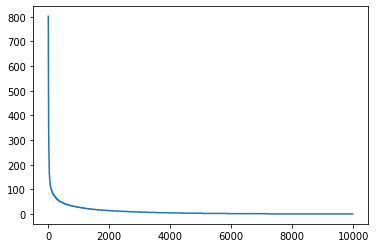

Products with at least 2 purchase: 7189
Products with less than 2 purchase: 2795


NameError: name 'minimum_order_size' is not defined

In [22]:
product_counts = transactions.groupby(transactions.product_id)['product_id'].count().sort_values(ascending=False).to_numpy()

plt.plot(product_counts)
plt.show()

minimum_purchaces = 2
product_group = transactions.loc[:, ['order_id', 'product_id']].groupby('product_id').count()
 
multi_purchase = product_group[(product_group.order_id >= minimum_purchaces)].count()
single_purchase = product_group[(product_group.order_id < minimum_purchaces)].count()
 
print('Products with at least',minimum_purchaces,'purchase:',multi_purchase['order_id'])
print('Products with less than',minimum_purchaces,'purchase:',single_purchase['order_id'])
 
# We can capture the list of mutiple product orders with this:
product_filter = product_group[(product_group.order_id >= minimum_order_size)].index.tolist()

filtered_df = transactions[transactions['product_id'].isin(product_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

# Orders with a single item

We will need to remove transactions that only included a single item

In [23]:
minimum_order_size = 2
order_group = filtered_df.loc[:, ['order_id', 'product_id']].groupby('order_id').count()
 
multi_order = order_group[(order_group.product_id >= minimum_order_size)].count()
single_order = order_group[(order_group.product_id < minimum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['product_id'])
print('Orders with less than',minimum_order_size,'products:',single_order['product_id'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.product_id >= minimum_order_size)].index.tolist()

NameError: name 'filtered_df' is not defined

In [24]:
filtered_df = filtered_df[filtered_df['order_id'].isin(order_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

NameError: name 'filtered_df' is not defined

# Returning Customers

We may also want to remove single visit customers. This is something to try and see if it reduces the sparcity. We may also want to remove users that make a much larger number of purchases than the average.

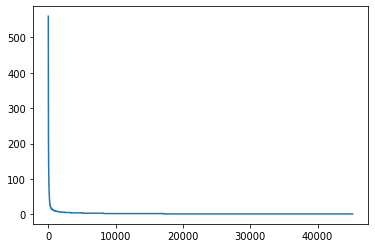

Users with at least 2 purchase: 17122
Users with less than 2 purchase: 28072


In [25]:
user_counts = transactions.groupby(transactions.user_id)['user_id'].count().sort_values(ascending=False).to_numpy()

plt.plot(user_counts)
plt.show()

minimum_purchaces = 2
user_group = transactions.loc[:, ['order_id', 'user_id']].groupby('user_id').count()
 
multi_purchase = user_group[(user_group.order_id >= minimum_purchaces)].count()
single_purchase = user_group[(user_group.order_id < minimum_purchaces)].count()
 
print('Users with at least',minimum_order_size,'purchase:',multi_purchase['order_id'])
print('Users with less than',minimum_order_size,'purchase:',single_purchase['order_id'])
 
# We can capture the list of mutiple product orders with this:
user_filter = user_group[(user_group.order_id >= minimum_order_size)].index.tolist()

In [26]:
filtered_df = filtered_df[filtered_df['user_id'].isin(user_filter)].copy()

print('Original dataframe length:', len(transactions))
print('Filtered dataframe length:', len(filtered_df))

NameError: name 'filtered_df' is not defined

# Data Sparcity

Let's take a look at the sparcity of the data. This will tell us how many products were purchased across multiple orders. This is directly related to how well a recommendation system can be trained.

In [27]:
transaction_list = list(np.sort(filtered_df.order_id.unique())) # Get our unique customers
item_list = list(filtered_df.product_id.unique()) # Get our unique products that were purchased
quantity_list = list(filtered_df.quantity) # All of our purchases

cols = filtered_df.order_id.astype(CategoricalDtype(categories=transaction_list, ordered=True)).cat.codes 
# Get the associated row indices
rows = filtered_df.product_id.astype(CategoricalDtype(categories=item_list, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape=(len(item_list), len(transaction_list)))

NameError: name 'filtered_df' is not defined

In [28]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

NameError: name 'purchases_sparse' is not defined

In [29]:
plt.figure(figsize=(15, 15))
plt.spy(purchases_sparse, markersize=1, aspect='auto')

NameError: name 'purchases_sparse' is not defined

<Figure size 1080x1080 with 0 Axes>

# Storing Interim Data

Now that we have the data cleaned up a bit and formatted correctly, we can save it to an interim file to be picked up by the model training algorithm.

In [ ]:
item_lookup = filtered_df[['product_id', 'category_code']].drop_duplicates() # Only get unique item/description pairs
item_lookup['product_id'] = item_lookup.product_id.astype(str) # Encode as strings for future lookup ease


In [ ]:
renamed_df = filtered_df[["order_id", "product_id","quantity", "price"]]
catalog.save("jewelry_transactions", renamed_df)


products_df = item_lookup.rename(columns={"StockCode":"product_id", "Description":"description"})
catalog.save("ecommerce_products", products_df)